To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

**[NEW] Llama-3 8b is trained on a crazy 15 trillion tokens! Llama-2 was 2 trillion.**

Use our [Llama-3 8b Instruct](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing) notebook for conversational style finetunes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /home/inflaton/code/projects/courses/novel-translation


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /home/inflaton/code/projects/courses/novel-translation/.env


True

In [4]:
import os

results_path = os.getenv("RESULTS_PATH")
results_path

'results/mac-results.csv'

In [5]:
import pandas as pd
from datasets import load_dataset

print("loading result file")
datasets = load_dataset("csv", data_files={"results": results_path})
datasets

loading result file


DatasetDict({
    results: Dataset({
        features: ['chinese', 'english', 'unsloth/Qwen2-0.5B-Instruct', 'unsloth/Qwen2-0.5B-Instruct(finetuned)', 'unsloth/Qwen2-1.5B-Instruct', 'unsloth/Qwen2-1.5B-Instruct(finetuned)', 'unsloth/Qwen2-7B-Instruct'],
        num_rows: 1133
    })
})

In [6]:
df = datasets["results"].to_pandas()

In [7]:
df.iloc[1001].to_list()

['停了一会儿，他突然问道：康明逊是孩子的父亲吧？',
 "After a long silence, he suddenly asked, 'Kang Mingxun is the father, isn't he?'",
 'A few minutes later, he suddenly asked: is康明逊是你的爸爸吗？',
 'After a pause, he asked, Was Kang Mingxun the father of the boy?',
 'A few seconds later, he asked suddenly: Is Kang Mingxun the father of the child?',
 "After a while, he suddenly asked, 'Kang Mingxun is the father of your child, right?'",
 'Pausing, he suddenly asked, "Is Kāng Míngxùn the father of the child?"']

In [8]:
df.columns

Index(['chinese', 'english', 'unsloth/Qwen2-0.5B-Instruct',
       'unsloth/Qwen2-0.5B-Instruct(finetuned)', 'unsloth/Qwen2-1.5B-Instruct',
       'unsloth/Qwen2-1.5B-Instruct(finetuned)', 'unsloth/Qwen2-7B-Instruct'],
      dtype='object')

In [9]:
df.columns.T

Index(['chinese', 'english', 'unsloth/Qwen2-0.5B-Instruct',
       'unsloth/Qwen2-0.5B-Instruct(finetuned)', 'unsloth/Qwen2-1.5B-Instruct',
       'unsloth/Qwen2-1.5B-Instruct(finetuned)', 'unsloth/Qwen2-7B-Instruct'],
      dtype='object')

In [10]:
metrics_df = pd.DataFrame(df.columns.T)[2:]
# metrics_df.reset_index(inplace=True)
metrics_df

,0
2,unsloth/Qwen2-0.5B-Instruct
3,unsloth/Qwen2-0.5B-Instruct(finetuned)
4,unsloth/Qwen2-1.5B-Instruct
5,unsloth/Qwen2-1.5B-Instruct(finetuned)
6,unsloth/Qwen2-7B-Instruct


In [11]:
metrics_df.rename(columns={0: "model"}, inplace=True)

In [12]:
metrics_df.columns

Index(['model'], dtype='object')

In [13]:
metrics_df.head()

,model
2,unsloth/Qwen2-0.5B-Instruct
3,unsloth/Qwen2-0.5B-Instruct(finetuned)
4,unsloth/Qwen2-1.5B-Instruct
5,unsloth/Qwen2-1.5B-Instruct(finetuned)
6,unsloth/Qwen2-7B-Instruct


In [14]:
metrics_df.reset_index(inplace=True)
metrics_df = metrics_df.drop(columns=["index"])
metrics_df

,model
0,unsloth/Qwen2-0.5B-Instruct
1,unsloth/Qwen2-0.5B-Instruct(finetuned)
2,unsloth/Qwen2-1.5B-Instruct
3,unsloth/Qwen2-1.5B-Instruct(finetuned)
4,unsloth/Qwen2-7B-Instruct


In [16]:
from translation_utils import *

accuracy = []
meteor = []
bleu_1 = []
rouge_l = []
all_metrics = []
for col in df.columns[2:]:
    metrics = calc_metrics(df["english"], df[col], debug=True)
    print(f"{col}: {metrics}")
    
    accuracy.append(metrics["accuracy"])
    meteor.append(metrics["meteor"])
    bleu_1.append(metrics["bleu_scores"]["bleu"])
    rouge_l.append(metrics["rouge_scores"]["rougeL"])
    all_metrics.append(metrics)

metrics_df["accuracy"] = accuracy
metrics_df["meteor"] = meteor
metrics_df["bleu_1"] = bleu_1
metrics_df["rouge_l"] = rouge_l
metrics_df["all_metrics"] = all_metrics

unsloth/Qwen2-0.5B-Instruct: {'accuracy': 0.0, 'correct_ids': [], 'meteor': 0.26682092609395136, 'bleu_scores': {'bleu': 0.050004191193532964, 'precisions': [0.32555012625848556, 0.07871253405994551, 0.025538396146217057, 0.009553670232386574], 'brevity_penalty': 1.0, 'length_ratio': 1.010036435905929, 'translation_length': 30493, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.32080392985205425, 'rouge2': 0.09481952943883189, 'rougeL': 0.2643075566849179, 'rougeLsum': 0.26428859909468416}}
unsloth/Qwen2-0.5B-Instruct(finetuned): {'accuracy': 0.00088261253309797, 'correct_ids': [147], 'meteor': 0.29032409482315213, 'bleu_scores': {'bleu': 0.06508609399238363, 'precisions': [0.3407579117113485, 0.09377291935878182, 0.03598822203642444, 0.01652015762352228], 'brevity_penalty': 0.9858565320713017, 'length_ratio': 0.9859556144418682, 'translation_length': 29766, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.3232732492239313, 'rouge2': 0.11239992918064917, 'rougeL': 0.26

In [17]:
metrics_df.describe()

,accuracy,meteor,bleu_1,rouge_l
count,5.000000,5.000000,5.000000,5.000000
mean,0.001412,0.324440,0.081426,0.309418
std,0.001006,0.044857,0.024671,0.042795
min,0.000000,0.266821,0.050004,0.264308
25%,0.000883,0.290324,0.065086,0.267388
50%,0.001765,0.335521,0.082854,0.323025
75%,0.001765,0.355038,0.097349,0.328354
max,0.002648,0.374497,0.111836,0.364012


In [18]:
metrics_df

,model,accuracy,meteor,bleu_1,rouge_l,all_metrics
0,unsloth/Qwen2-0.5B-Instruct,0.000000,0.266821,0.050004,0.264308,"{'accuracy': 0.0, 'correct_ids': [], 'meteor':..."
1,unsloth/Qwen2-0.5B-Instruct(finetuned),0.000883,0.290324,0.065086,0.267388,"{'accuracy': 0.00088261253309797, 'correct_ids..."
2,unsloth/Qwen2-1.5B-Instruct,0.001765,0.335521,0.082854,0.328354,"{'accuracy': 0.00176522506619594, 'correct_ids..."
3,unsloth/Qwen2-1.5B-Instruct(finetuned),0.002648,0.355038,0.097349,0.323025,"{'accuracy': 0.00264783759929391, 'correct_ids..."
4,unsloth/Qwen2-7B-Instruct,0.001765,0.374497,0.111836,0.364012,"{'accuracy': 0.00176522506619594, 'correct_ids..."


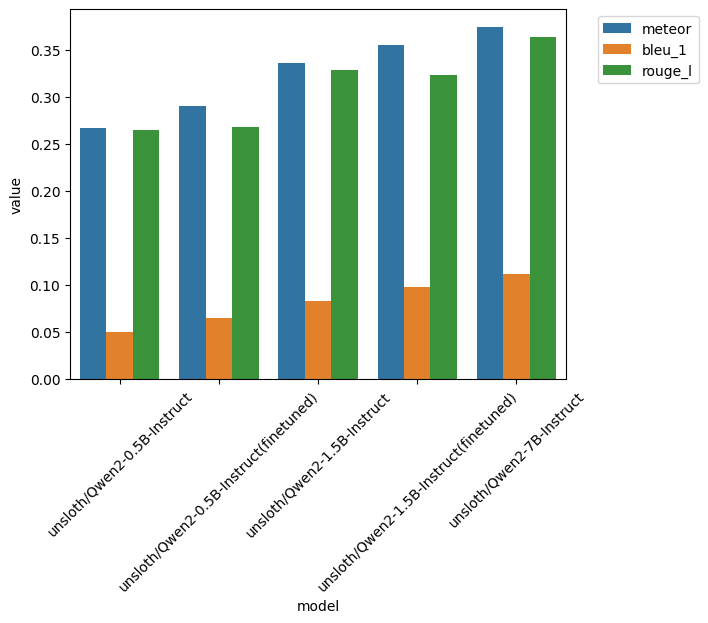

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and 'category', 'value1', 'value2', 'value3' are columns in `df`
df_melted = pd.melt(
    metrics_df, id_vars="model", value_vars=["meteor", "bleu_1", "rouge_l"]
)

sns.barplot(x="model", y="value", hue="variable", data=df_melted)

plt.xticks(rotation=45)  # Rotate labels by 45 degrees

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

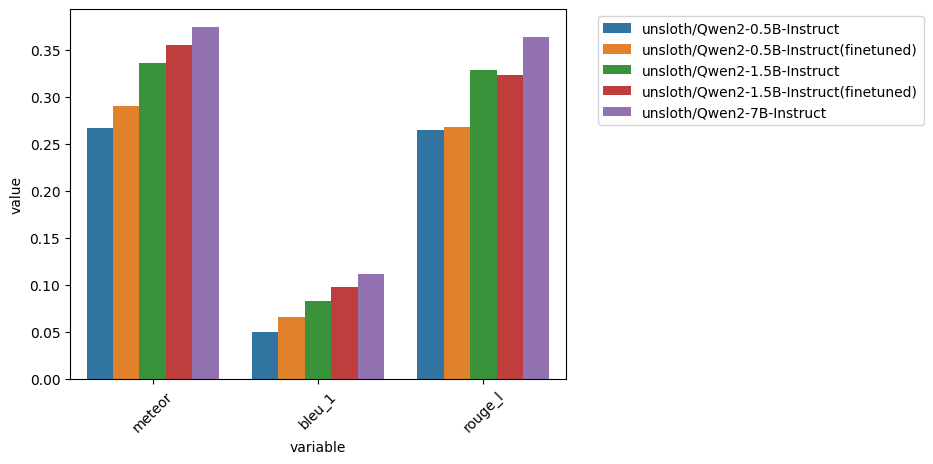

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and 'model', 'accuracy', 'meteor', 'bleu_1', 'rouge_l' are columns in `df`
df_melted = pd.melt(
    metrics_df, id_vars="model", value_vars=["meteor", "bleu_1", "rouge_l"]
)

sns.barplot(x="variable", y="value", hue="model", data=df_melted)

plt.xticks(rotation=45)  # Rotate labels by 45 degrees

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()